In [2]:
!pip install opencv-python

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.signal import convolve2d
from utils import *

In [4]:
boards = os.listdir('boards')

In [5]:
len(boards)

999

In [17]:
b = f'boards/{boards[0]}'

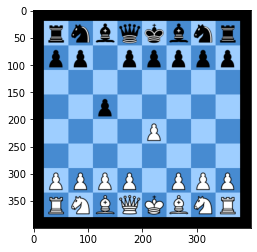

In [18]:
img = cv2.imread(b)
plt.imshow(img)

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [9]:
def show(img):
    plt.imshow(img, cmap='gray')

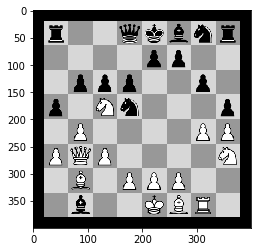

In [10]:
show(gray)

TF functions for reference.

https://github.com/Elucidation/tensorflow_chessbot/blob/master/tensorflow_compvision.ipynb

In [11]:

def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def gradientx(x):
  """Compute the x gradient of an array"""
  gradient_x = make_kernel([[-1.,0., 1.],
                            [-1.,0., 1.],
                            [-1.,0., 1.]])
  return simple_conv(x, gradient_x)

def gradienty(x):
  """Compute the x gradient of an array"""
  gradient_y = make_kernel([[-1., -1, -1],[0.,0,0], [1., 1, 1]])
  return simple_conv(x, gradient_y)

def corners(x):
  """Find chess square corners in an array"""
  chess_corner = make_kernel([[-1., 0, 1],[0., 0., 0.], [1.,0, -1]])
  return simple_conv(x, chess_corner)

# Following are meant for binary images
def dilate(x, size=3):
  """Dilate"""
  kernel = make_kernel(np.ones([size,size], dtype=np.float32))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(1),
                          np.float32(2))-np.float32(1)

def erode(x, size=3):
  """Erode"""
  kernel = make_kernel(np.ones([size,size]))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(size*size-1),
                          np.float32(size*size))-np.float32(size*size-1)

def opening(x, size=3):
    return dilate(erode(x,size),size)

def closing(x, size=3):
    return erode(dilate(x,size),size)

def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)

Make horizontal and vertical Sobel filters.

In [12]:
horiz = np.array([[1,2,1],
                     [0,0,0],
                     [-1,-2,-1]])
horiz

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

In [13]:
vert = np.array([[1,0,-1],
                 [2,0,-2],
                 [1,0,-1]])

vert

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

In [14]:
blurred = cv2.blur(gray,(3,3))

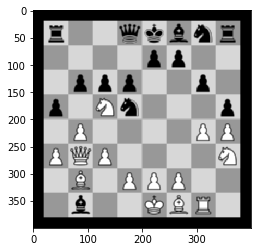

In [15]:
plt.imshow(blurred, cmap='gray')

In [16]:
hgrad = convolve2d(blurred, horiz)
vgrad = convolve2d(blurred, vert)

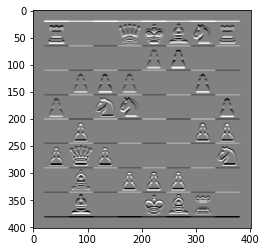

In [17]:
plt.imshow(hgrad, cmap='gray')

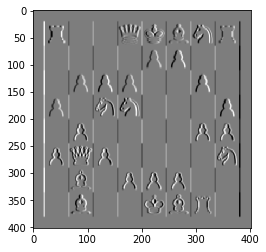

In [18]:
plt.imshow(vgrad, cmap='gray')

In [19]:
k = np.ones((3,3), np.uint8)

In [20]:
hgrad = cv2.erode(hgrad.astype(np.uint8), k)
vgrad = cv2.erode(vgrad.astype(np.uint8), k)

Sum absolute values horizontally and vertically

In [21]:
vlines = np.abs(vgrad).sum(axis=0)
hlines = np.abs(hgrad).sum(axis=1)

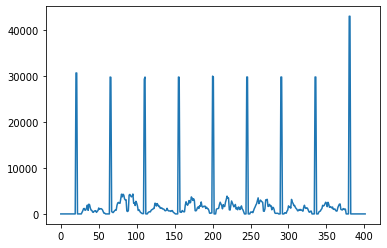

In [22]:
plt.plot(vlines)

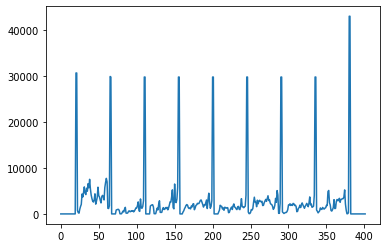

In [23]:
plt.plot(hlines)

8 spikes!!!

In [24]:
# blur
blurred = cv2.blur(gray,(3,3))

# horizontal and vertical Sobel
hgrad = convolve2d(blurred, horiz)
vgrad = convolve2d(blurred, vert)

# erode
k = np.ones((3,3), np.uint8)
hgrad = cv2.erode(hgrad.astype(np.uint8), k)
vgrad = cv2.erode(vgrad.astype(np.uint8), k)

# sum absolute values vertically and horizontally
vlines = np.abs(vgrad).sum(axis=0)
hlines = np.abs(hgrad).sum(axis=1)

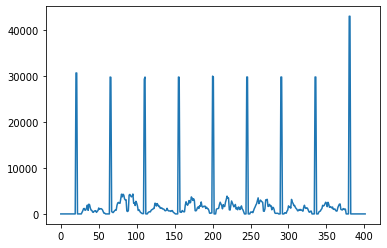

In [25]:
plt.plot(vlines)

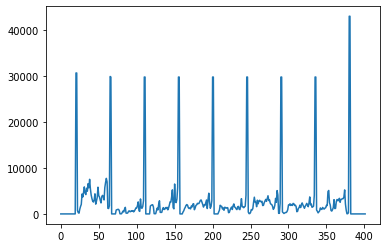

In [26]:
plt.plot(hlines)

In [16]:
def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

In [28]:
skel = skeletonize_1d(vlines)

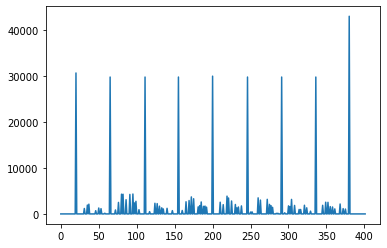

In [29]:
plt.plot(skel)

In [30]:
skel.max()

42935

In [31]:
vticks = np.where(skel>(skel.max()/2))[0]

In [32]:
vticks

array([ 20,  65, 111, 155, 200, 246, 291, 336, 380])

In [33]:
skel = skeletonize_1d(hlines)
hticks = np.where(skel>(skel.max()/2))[0]
hticks

array([ 20,  65, 111, 156, 201, 246, 291, 336, 380])

In [34]:
_img = img.copy()

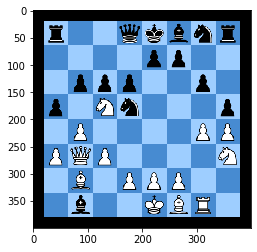

In [35]:
plt.imshow(_img)

In [36]:
for tick in vticks:
    _img = cv2.line(_img, (0,tick), (400,tick), (255,0,0), thickness=3)

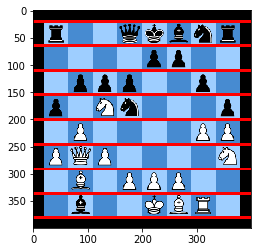

In [37]:
plt.imshow(_img)

In [38]:
for tick in hticks:
    _img = cv2.line(_img, (tick,0), (tick,400), (0,255,0), thickness=3)

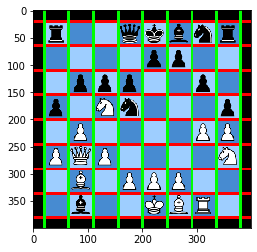

In [39]:
plt.imshow(_img)

Booyah!

In [185]:
for i in range(len(hticks)-1):
    for j in range(len(vticks)-1):
        xmin = hticks[i]
        xmax = hticks[i+1]
        ymin = vticks[j]
        ymax = vticks[j+1]
        # check this shit, the order is weird in opencv
        square = gray[xmin:xmax, ymin:ymax]
        cv2.imwrite(f'squares/{i}{j}.png', square)

Incredibly, it works!

In [40]:
b

'boards/r__qkbnr____pp___ppp__p_p_Nn___p_P____PPPQP____N_B_PPP___b__KBR_.png'

Make a folder for each label. Save pieces to appropriate folder based on filename.

In [81]:
# labels = 'KQRBNPkqrbnp_'

In [88]:
labels = ['WK', 'WQ', 'WR', 'WB', 'WN', 'WP',
          'BK', 'BQ', 'BR', 'BB', 'BN', 'BP',
          '_']

In [89]:
len(labels)

13

In [43]:
from pathlib import Path

In [90]:
squares = Path('squares')

for label in labels:
    (squares/label).mkdir(exist_ok=True)

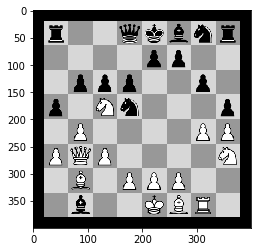

In [91]:
show(gray)

Evidently I started from the top left, and proceeded left to right, top to bottom.

In [92]:
pos = Path(b).stem
pos

'r__qkbnr____pp___ppp__p_p_Nn___p_P____PPPQP____N_B_PPP___b__KBR_'

In [20]:
def save_squares(board, gray, hticks, vticks):
    pos = Path(board).stem
    k = 0
    for i in range(len(hticks)-1):
        for j in range(len(vticks)-1):
            xmin = hticks[i]
            xmax = hticks[i+1]
            ymin = vticks[j]
            ymax = vticks[j+1]
            square = gray[xmin:xmax, ymin:ymax]
            piece = pos[k]
            if piece=='_':
                label = piece
            else:
                color = 'B' if piece.isupper() else 'W'
                label = color + piece.upper()
            folder = f'squares/{label}'
            n = len(os.listdir(folder))
            fn = f'{folder}/{n}.png'
#             print(fn)
            cv2.imwrite(fn, square)
            k+=1

In [68]:
bp = Path(b)

In [71]:
bp.stem

'r__qkbnr____pp___ppp__p_p_Nn___p_P____PPPQP____N_B_PPP___b__KBR_'

In [12]:
def clean_out(folder):
    [os.remove(f'{folder}/{f}') for f in os.listdir(folder) if not f.startswith('.')]

In [9]:
labels = ['WK', 'WQ', 'WR', 'WB', 'WN', 'WP',
          'BK', 'BQ', 'BR', 'BB', 'BN', 'BP',
          '_']

In [26]:
for label in labels:
    folder = f'squares/{label}'
    clean_out(folder)

In [96]:
len(boards)

999

In [27]:
for i,board in enumerate(boards):
    print(f'Processing board {i}')
    fn = f'boards/{board}'
    img = cv2.imread(fn)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    horiz = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

    vert = np.array([[1,0,-1],
                     [2,0,-2],
                     [1,0,-1]])

    # blur
    blurred = cv2.blur(gray,(3,3))

    # horizontal and vertical Sobel
    hgrad = convolve2d(blurred, horiz)
    vgrad = convolve2d(blurred, vert)

    # erode
    k = np.ones((3,3), np.uint8)
    hgrad = cv2.erode(hgrad.astype(np.uint8), k)
    vgrad = cv2.erode(vgrad.astype(np.uint8), k)

    # sum absolute values vertically and horizontally
    vlines = np.abs(vgrad).sum(axis=0)
    hlines = np.abs(hgrad).sum(axis=1)

    vskel = skeletonize_1d(vlines)
    vticks = np.where(vskel>(vskel.max()/2))[0]

    hskel = skeletonize_1d(hlines)
    hticks = np.where(hskel>(hskel.max()/2))[0]
    
    if len(vticks)==9 and len(hticks)==9:
        save_squares(board, gray, hticks, vticks)
    else:
        print(f"Board {board} didn't validate")

Processing board 0
Processing board 1
Processing board 2
Processing board 3
Processing board 4
Processing board 5
Processing board 6
Processing board 7
Processing board 8
Processing board 9
Processing board 10
Processing board 11
Processing board 12
Processing board 13
Processing board 14
Processing board 15
Processing board 16
Processing board 17
Processing board 18
Processing board 19
Processing board 20
Processing board 21
Processing board 22
Processing board 23
Processing board 24
Processing board 25
Processing board 26
Processing board 27
Processing board 28
Processing board 29
Processing board 30
Processing board 31
Processing board 32
Processing board 33
Processing board 34
Processing board 35
Processing board 36
Processing board 37
Processing board 38
Processing board 39
Processing board 40
Processing board 41
Processing board 42
Processing board 43
Processing board 44
Processing board 45
Processing board 46
Processing board 47
Processing board 48
Processing board 49
Processing

Processing board 396
Processing board 397
Processing board 398
Processing board 399
Processing board 400
Processing board 401
Processing board 402
Processing board 403
Processing board 404
Processing board 405
Processing board 406
Processing board 407
Processing board 408
Processing board 409
Processing board 410
Processing board 411
Processing board 412


error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Pipeline

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.signal import convolve2d
from pathlib import Path

In [2]:
labels = ['WK', 'WQ', 'WR', 'WB', 'WN', 'WP',
          'BK', 'BQ', 'BR', 'BB', 'BN', 'BP',
          '_']

In [20]:
def clean_out(folder):
    [os.remove(f'{folder}/{f}') for f in os.listdir(folder) if not f.startswith('.')]

In [21]:
# for label in labels:
#     folder = f'squares/{label}'
#     clean_out(folder)

In [10]:
for label in labels:
    folder = f'squares/{label}'
    os.mkdir(folder)

In [3]:
def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

In [1]:
def save_squares(fn, img, hticks, vticks):
    pos = Path(fn).stem
    k = 0
    for i in range(len(hticks)-1):
        for j in range(len(vticks)-1):
            xmin = hticks[i]
            xmax = hticks[i+1]
            ymin = vticks[j]
            ymax = vticks[j+1]
            square = img[xmin:xmax, ymin:ymax]
            piece = pos[k]
            if piece=='_':
                label = piece
            else:
                color = 'W' if piece.isupper() else 'B'
                label = color + piece.upper()
            folder = f'squares/{label}'
            n = len(os.listdir(folder))
            fn = f'{folder}/{n}.png'
            cv2.imwrite(fn, square)
            k+=1

In [2]:
def convert_boards(boards):
    for i,fn in enumerate(boards):
        print(f'Board {i}')
        
        path = f'boards/{fn}'
        img = cv2.imread(path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        horiz = np.array([[1,2,1],
                             [0,0,0],
                             [-1,-2,-1]])

        vert = np.array([[1,0,-1],
                         [2,0,-2],
                         [1,0,-1]])

        # blur
        blurred = cv2.blur(gray,(3,3))

        # horizontal and vertical Sobel
        hgrad = convolve2d(blurred, horiz)
        vgrad = convolve2d(blurred, vert)

        # erode
        k = np.ones((3,3), np.uint8)
        hgrad = cv2.erode(hgrad.astype(np.uint8), k)
        vgrad = cv2.erode(vgrad.astype(np.uint8), k)

        # sum absolute values vertically and horizontally
        vlines = np.abs(vgrad).sum(axis=0)
        hlines = np.abs(hgrad).sum(axis=1)

        vskel = skeletonize_1d(vlines)
        vticks = np.where(vskel>(vskel.max()/2))[0]

        hskel = skeletonize_1d(hlines)
        hticks = np.where(hskel>(hskel.max()/2))[0]

        if len(vticks)==9 and len(hticks)==9:
            save_squares(fn, img, hticks, vticks)
        else:
            print(f"Board {board} didn't validate")

In [8]:
boards = os.listdir('boards')

In [11]:
convert_boards(boards[:100])

Board 0
Board 1
Board 2
Board 3
Board 4
Board 5
Board 6
Board 7
Board 8
Board 9
Board 10
Board 11
Board 12
Board 13
Board 14
Board 15
Board 16
Board 17
Board 18
Board 19
Board 20
Board 21
Board 22
Board 23
Board 24
Board 25
Board 26
Board 27
Board 28
Board 29
Board 30
Board 31
Board 32
Board 33
Board 34
Board 35
Board 36
Board 37
Board 38
Board 39
Board 40
Board 41
Board 42
Board 43
Board 44
Board 45
Board 46
Board 47
Board 48
Board 49
Board 50
Board 51
Board 52
Board 53
Board 54
Board 55
Board 56
Board 57
Board 58
Board 59
Board 60
Board 61
Board 62
Board 63
Board 64
Board 65
Board 66
Board 67
Board 68
Board 69
Board 70
Board 71
Board 72
Board 73
Board 74
Board 75
Board 76
Board 77
Board 78
Board 79
Board 80
Board 81
Board 82
Board 83
Board 84
Board 85
Board 86
Board 87
Board 88
Board 89
Board 90
Board 91
Board 92
Board 93
Board 94
Board 95
Board 96
Board 97
Board 98
Board 99


## Lichess

In [11]:
from utils import *

In [71]:
lichess = Path('lichess')

In [72]:
lichess

Path('lichess')

In [73]:
labels

'r_b_r_kQQpQ__pQQ__prqn_Q____Q_B_____P_PN__NP___NPNP__N_QR__QK__R'

In [74]:
for label in labels:
    (lichess/'squares'/label).mkdir(exist_ok=True)

In [75]:
fen = 'r1b1r1k1/ppp2ppp/2pbqn2/4p1B1/4P1PN/2NP3P/PPP2P2/R2QK2R b KQ - 2 11'

In [76]:
board = chess.Board(fen)

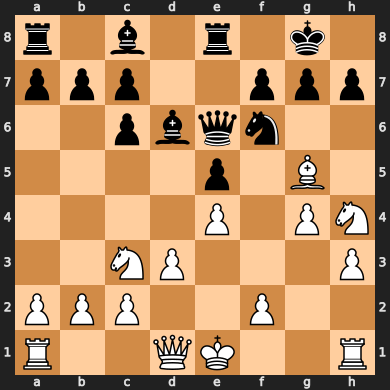

In [77]:
board

In [78]:
label = fen2label(fen)

In [79]:
label

'r_b_r_k_ppp__ppp__pbqn______p_B_____P_PN__NP___PPPP__P__R__QK__R'

### Make squares

In [80]:
import cv2

In [81]:
def save_squares(img):
    h,w,_ = img.shape
    k = 0
    for y in range(8):
        for x in range(8):
            square = img[y*h//8:(y+1)*h//8, x*w//8:(x+1)*w//8]
            cv2.imwrite(f'lichess/temp/{k}.png', square)
            k+=1

In [88]:
img = cv2.imread(f'sample.png')

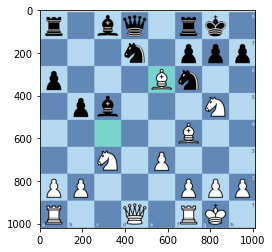

In [89]:
show(img)

In [90]:
save_squares(img)

### Predict

In [91]:
learner = load_learner('lichess_finetuned.pkl')
temp = Path('lichess/temp')

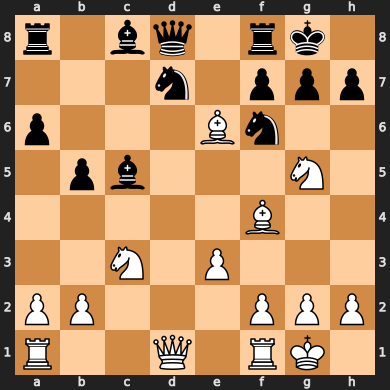

In [92]:
items = []
for i in range(64):
    fn = f'{i}.png'
    path = temp/fn
    item = PILImage.create(path)
    items.append(item)

dl = learner.dls.test_dl(items)

_, __, preds = learner.get_preds(dl=dl, with_decoded=True)
classes = learner.dls.vocab
preds = [classes[pred] for pred in preds]
labels = ''.join([label_lib[pred] for pred in preds])
fen = label2fen(labels)
board = chess.Board(fen)
board

## Make lichess data

In [37]:
lichess

Path('lichess')

In [38]:
lichess.ls()

(#3) [Path('lichess/temp'),Path('lichess/squares'),Path('lichess/boards')]

In [56]:
label_lib

{'WK': 'K',
 'WQ': 'Q',
 'WR': 'R',
 'WB': 'B',
 'WN': 'N',
 'WP': 'P',
 'BK': 'k',
 'BQ': 'q',
 'BR': 'r',
 'BB': 'b',
 'BN': 'n',
 'BP': 'p',
 '_': '_'}

In [59]:
def save_squares(img, labels):
    h,w,_ = img.shape
    k = 0
    for y in range(8):
        for x in range(8):
            square = img[y*h//8:(y+1)*h//8, x*w//8:(x+1)*w//8]
            piece = labels[k]
            if piece=='_':
                label = piece
            else:
                color = 'W' if piece.isupper() else 'B'
                label = color + piece.upper()
            folder = f'lichess/squares/{label}'
            n = len(os.listdir(folder))
            fn = f'{folder}/{n}.png'
            cv2.imwrite(fn, square)
            k+=1

In [60]:
board_dir = lichess/'boards'
boards = board_dir.ls()
for board in boards:
    img = cv2.imread(str(board))
    label = board.stem
    save_squares(img, label)

## Finetune

In [61]:
learner = load_learner('export.pkl')

In [62]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  get_y = parent_label,
                  splitter = RandomSplitter(),
                  item_tfms = Resize(224),
                  batch_tfms=aug_transforms(size=224))

In [63]:
dsets = dblock.datasets('lichess/squares')
dsets.train[0]

(PILImage mode=RGB size=89x89, TensorCategory(12))

In [64]:
dls = dblock.dataloaders('lichess/squares')

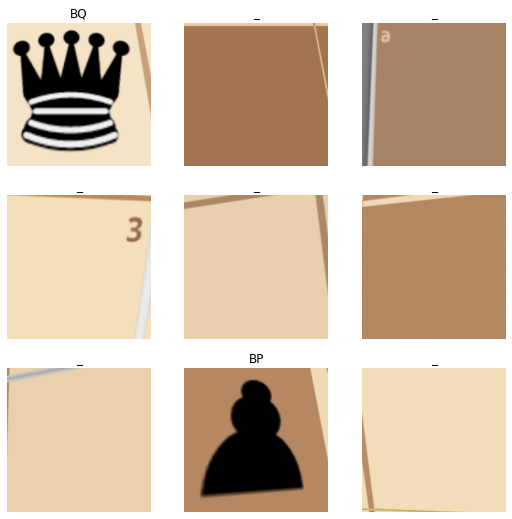

In [65]:
dls.show_batch()

In [68]:
learner.dls = dls

In [69]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.012037,0.000064,0.000000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.017220,0.000042,0.000000,00:07


In [70]:
learner.export('lichess_finetuned.pkl')